In [271]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore") 

# For processing
import math
import random
import datetime as dt
import matplotlib.dates as mdates

# For visualization
import matplotlib.pyplot as plt

# Libraries for model training
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [272]:
# Reading AAPL dataset
ticker = "AAPL"

df = pd.read_csv(f'data/stocks/{ticker}.csv', parse_dates=['Date'])
df["Difference"] = df["Close"].diff()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Difference
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400,NaN
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200,-0.026786
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000,-0.035714
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400,0.011161
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400,0.013393


In [273]:
# Defining a function that will contain stocks data for a specific company
def specific_data(company, df, start = dt.datetime(2000,1,1), end = dt.datetime(2024,1,1)):
    # df["Name"] = company
    date_filtered_data = df[(df['Date'] > start) & (df['Date'] < end)]
    return date_filtered_data

df = specific_data(ticker, df)

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Difference
4815,2000-01-03,3.745536,4.017857,3.631696,3.997768,3.470226,133949200,0.325893
4816,2000-01-04,3.866071,3.950893,3.613839,3.660714,3.177650,128094400,-0.337054
4817,2000-01-05,3.705357,3.948661,3.678571,3.714286,3.224152,194580400,0.053571
4818,2000-01-06,3.790179,3.821429,3.392857,3.392857,2.945139,191993200,-0.321429
4819,2000-01-07,3.446429,3.607143,3.410714,3.553571,3.084645,115183600,0.160714


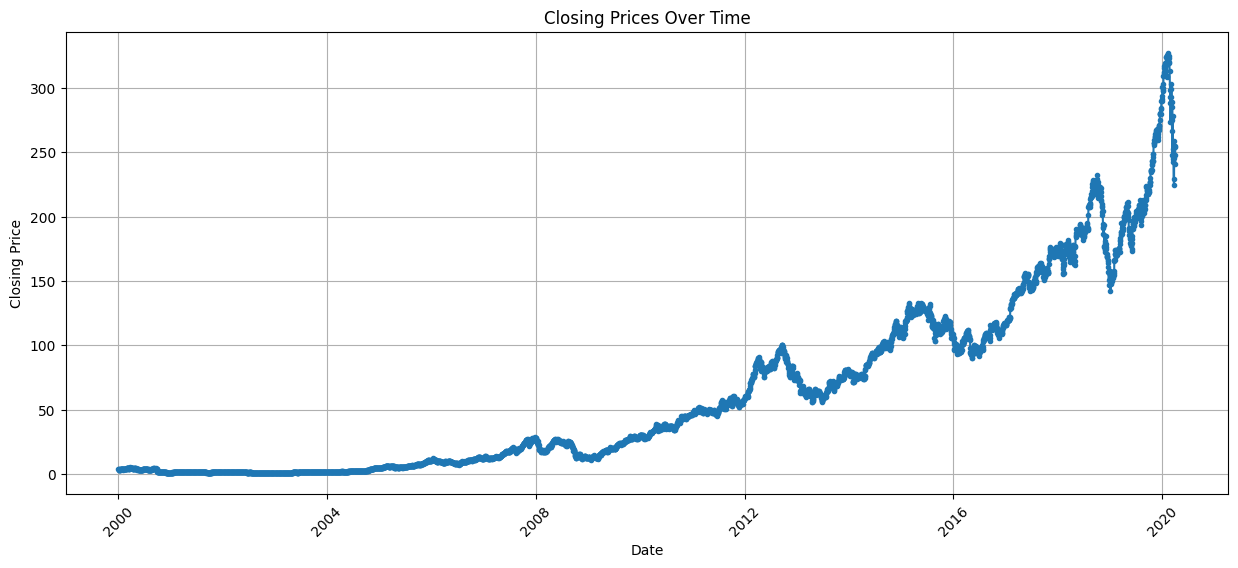

In [274]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Close'], marker='.')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

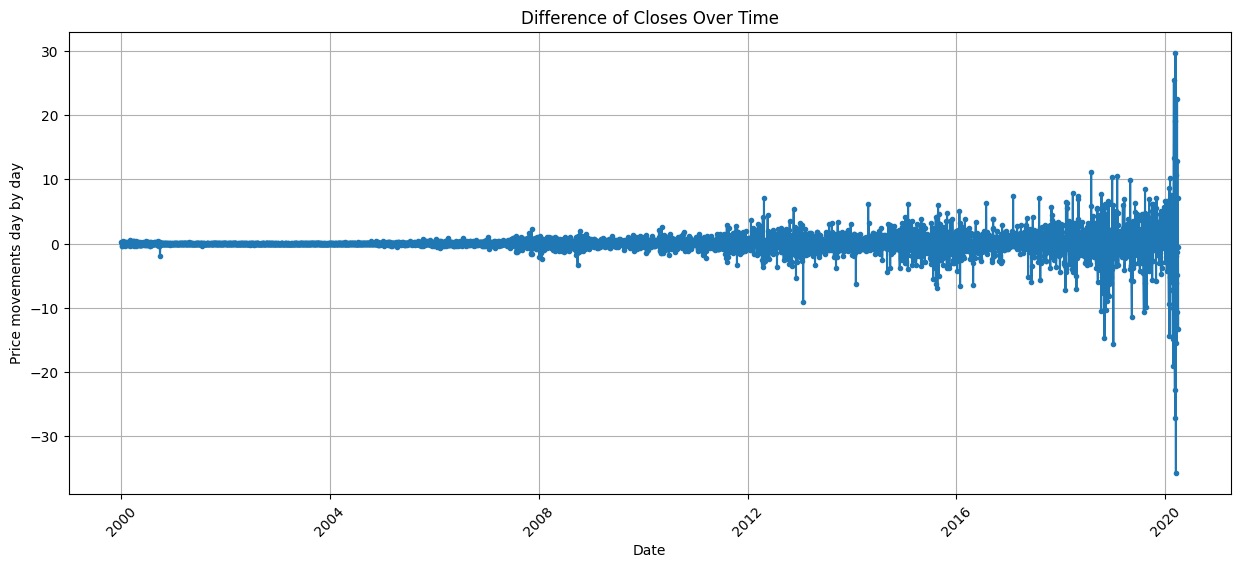

In [284]:
# Convert 'Date' column to datetime

plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Difference'], marker='.')
plt.title('Difference of Closes Over Time')
plt.xlabel('Date')
plt.ylabel('Price movements day by day')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [293]:
scaler = MinMaxScaler()
close_scaler = MinMaxScaler()
without_date = df.drop( "Date", axis="columns")

df_train, df_test = train_test_split(without_date, test_size=0.2, shuffle=False)

close_scaler.fit(np.array(df_train["Close"]).reshape(-1,1))
print(f"{close_scaler.scale_}, {close_scaler.min_}, ")
scaled_train = scaler.fit_transform(df_train)
scaled_test = scaler.transform(df_test)

print(scaled_train.shape)
print(scaled_test.shape)

[0.00757215], [-0.00709619], 
(4075, 7)
(1019, 7)


In [294]:
past = 7

# Prepare sequences for LSTM
X_train, y_train = [], []
for i in range(past, len(scaled_train)):
    X_train.append(scaled_train[i - past:i])
    y_train.append(scaled_train[i])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(past, len(scaled_test)):
    X_test.append(scaled_test[i - past:i])
    y_test.append(scaled_test[i])
X_test, y_test = np.array(X_test), np.array(y_test)

print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(4068, 7, 7)
(4068, 7)
Testing set size:-
(1012, 7, 7)
(1012, 7)


(None, None)

In [295]:
# Initialize a sequential model
model = Sequential()

# First LSTM layer with 50 units, input shape, and return sequences
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))         # Adding dropout to prevent overfitting

# Second LSTM layer with 50 units and return sequences
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.1))

# Third LSTM layer with 50 units
model.add(LSTM(units=50))
model.add(Dropout(0.1))

# Add a dense output layer with one unit
model.add(Dense(1))

model.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 7, 50)             11600     
                                                                 
 dropout_48 (Dropout)        (None, 7, 50)             0         
                                                                 
 lstm_49 (LSTM)              (None, 7, 50)             20200     
                                                                 
 dropout_49 (Dropout)        (None, 7, 50)             0         
                                                                 
 lstm_50 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_50 (Dropout)        (None, 50)                0         
                                                                 
 dense_16 (Dense)            (None, 1)               

In [296]:
model.compile(loss='mse',optimizer='adam')

In [297]:
# Defining our callbacks
checkpoints = ModelCheckpoint(filepath = 'my_weights.h5', save_best_only = True)
# Defining our early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training our lstm model
model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=32,
          batch_size=16,
          verbose=1,
          callbacks= [checkpoints, early_stopping])

Epoch 1/32
255/255 [==============================] - 6s 11ms/step - loss: 0.0393 - val_loss: 0.3265
Epoch 2/32
255/255 [==============================] - 2s 7ms/step - loss: 0.0370 - val_loss: 0.3238
Epoch 3/32
255/255 [==============================] - 2s 7ms/step - loss: 0.0369 - val_loss: 0.3240
Epoch 4/32
255/255 [==============================] - 2s 7ms/step - loss: 0.0369 - val_loss: 0.3386
Epoch 5/32
255/255 [==============================] - 2s 7ms/step - loss: 0.0369 - val_loss: 0.3297
Epoch 6/32
255/255 [==============================] - 2s 7ms/step - loss: 0.0368 - val_loss: 0.3153
Epoch 7/32
255/255 [==============================] - 2s 7ms/step - loss: 0.0369 - val_loss: 0.3215
Epoch 8/32
255/255 [==============================] - 2s 7ms/step - loss: 0.0368 - val_loss: 0.3361
Epoch 9/32
255/255 [==============================] - 2s 7ms/step - loss: 0.0367 - val_loss: 0.3324
Epoch 10/32
255/255 [==============================] - 2s 7ms/step - loss: 0.0367 - val_loss: 0.319

In [298]:
# Let's do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

32/32 [==============================] - 0s 2ms/step


In [299]:
# Transform back to original form
# train_predict=scaler.inverse_transform(train_predict)
# test_predict=scaler.inverse_transform(test_predict)

test_predict = close_scaler.inverse_transform(test_predict)
train_predict = close_scaler.inverse_transform(train_predict)

[[ 90.15071]
 [ 90.2495 ]
 [ 90.28907]
 ...
 [150.47658]
 [150.62532]
 [151.41829]]


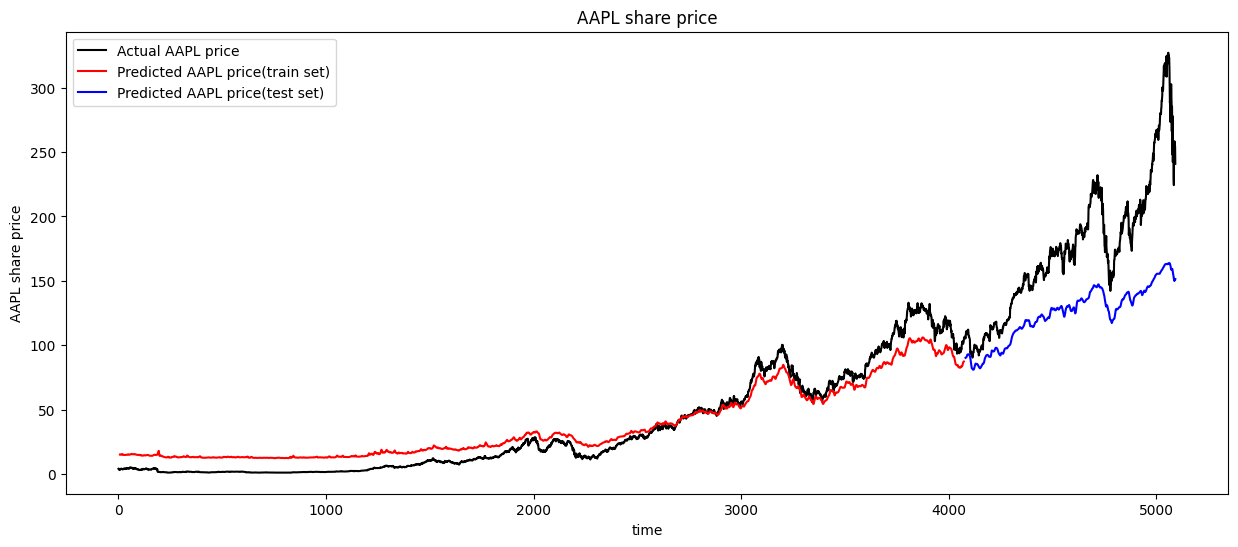

In [301]:
# Set the number of previous time steps to consider for plotting
look_back = past

# Initialize an array for plotting the train predictions
trainPredictPlot = np.empty_like(df["Close"])
trainPredictPlot[:] = np.nan
# Assign the predicted values to the appropriate location for train predictions
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()

# Initialize an array for plotting the test predictions
testPredictPlot = np.empty_like(df["Close"])
testPredictPlot[:] = np.nan
# Calculate the starting index for the test predictions
test_start = len(df) - len(test_predict)
# Assign the predicted values to the appropriate location for test predictions
testPredictPlot[test_start:] = test_predict.flatten()

# Rescale the scaled data back to its original scale using the scaler
original_scaled_data = np.array(df["Close"])

# Plotting the baseline data, training predictions, and test predictions
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual {ticker} price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted {ticker} price(train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted {ticker} price(test set)")

plt.title(f"{ticker} share price")
plt.xlabel("time")
plt.ylabel(f"{ticker} share price")
plt.legend()
plt.show()

In [ ]:
# teching the model for close differences
scaler = MinMaxScaler()
difference_scaler = MinMaxScaler()
without_date = df.drop( "Date", axis="columns")

df_train, df_test = train_test_split(without_date, test_size=0.2, shuffle=False)

difference_scaler.fit(np.array(df_train["Difference"]).reshape(-1,1))
print(f"{difference_scaler.scale_}, {difference_scaler.min_}, ")
scaled_train = scaler.fit_transform(df_train)
scaled_test = scaler.transform(df_test)

past = 7

# Prepare sequences for LSTM
X_train, y_train = [], []
for i in range(past, len(scaled_train)):
    X_train.append(scaled_train[i - past:i])
    y_train.append(scaled_train[i])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(past, len(scaled_test)):
    X_test.append(scaled_test[i - past:i])
    y_test.append(scaled_test[i])
X_test, y_test = np.array(X_test), np.array(y_test)

print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)